In [1]:
# Imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.regression.rolling import RollingOLS

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [2]:
# Clean Data
import pandas as pd
import numpy as np

# Read the CRSP data
print("Reading CRSP data...")
crsp = pd.read_csv('crsp_1926_2020.csv')

# Display basic information about the data
print("\nInitial data shape:", crsp.shape)
print("\nColumns in the dataset:")
print(crsp.columns.tolist())
print("\nSample of the data:")
print(crsp.head())

# Apply cleaning conditions
print("\nCleaning data...")

# 1. Only include ordinary/common shares (SHRCD = 10 or 11)
crsp = crsp[crsp['SHRCD'].isin([10, 11])]

# 2. Only include stocks listed on NYSE, AMEX, or NASDAQ (EXCHCD = 1, 2, 3)
crsp = crsp[crsp['EXCHCD'].isin([1, 2, 3])]

# 3. Set negative prices to NA
crsp.loc[crsp['PRC'] < 0, 'PRC'] = np.nan

# Display cleaned data information
print("\nCleaned data shape:", crsp.shape)
print("\nNumber of missing prices after cleaning:", crsp['PRC'].isna().sum())

# Save cleaned data
print("\nSaving cleaned data...")
crsp.to_csv('crsp_cleaned.csv', index=False)
print("Done!") 

Reading CRSP data...

Initial data shape: (4705169, 7)

Columns in the dataset:
['PERMNO', 'date', 'SHRCD', 'EXCHCD', 'PRC', 'RET', 'SHROUT']

Sample of the data:
   PERMNO        date  SHRCD  EXCHCD     PRC        RET  SHROUT
0   10000  1985-12-31    NaN     NaN     NaN        NaN     NaN
1   10000  1986-01-31   10.0     3.0 -4.3750          C  3680.0
2   10000  1986-02-28   10.0     3.0 -3.2500  -0.257143  3680.0
3   10000  1986-03-31   10.0     3.0 -4.4375   0.365385  3680.0
4   10000  1986-04-30   10.0     3.0 -4.0000  -0.098592  3793.0

Cleaning data...

Cleaned data shape: (3630644, 7)

Number of missing prices after cleaning: 759174

Saving cleaned data...
Done!


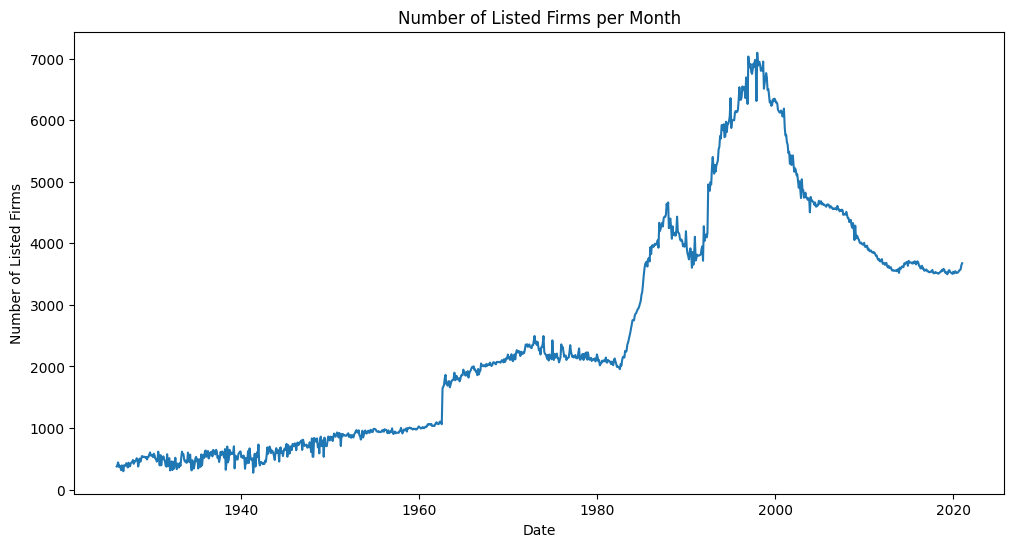

In [3]:
# =============================================================================
# SECTION 1: Data Cleaning and Summary Statistics
# =============================================================================

def load_crsp_data():
    """
    Load the cleaned CRSP data. (Assumes crsp_cleaned.csv is already filtered by share and exchange.)
    Also converts key columns to numeric and drops rows with missing PRC or RET.
    """
    df = pd.read_csv("crsp_cleaned.csv")
    df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
    # Convert numeric columns; any problematic entries become NaN.
    df['RET'] = pd.to_numeric(df['RET'], errors='coerce')
    df['PRC'] = pd.to_numeric(df['PRC'], errors='coerce')
    df['SHROUT'] = pd.to_numeric(df['SHROUT'], errors='coerce')
    # Drop rows where essential numeric values are missing.
    df = df.dropna(subset=['PRC', 'RET', 'SHROUT'])
    return df

df_crsp = load_crsp_data()

def plot_listed_firms(df):
    """
    Plot the number of listed firms (unique PERMNO) per month.
    """
    # Group by date and count unique PERMNO values.
    counts = df.groupby('date')['PERMNO'].nunique()
    plt.figure(figsize=(12,6))
    plt.plot(counts.index, counts.values)
    plt.xlabel('Date')
    plt.ylabel('Number of Listed Firms')
    plt.title('Number of Listed Firms per Month')
    plt.show()

plot_listed_firms(df_crsp)

In [10]:
# =============================================================================
# SECTION 2: Replicate Size Strategy
# =============================================================================

def size_strategy(df):
    """
    Compute size portfolios by sorting stocks into deciles based on market capitalization.
    Uses both equal- and value-weighted returns and forms a long-short portfolio 
    (small decile minus big decile).
    """
    # Compute market capitalization = |PRC| * SHROUT.
    df = df.copy()
    df['mktcap'] = df['PRC'].abs() * df['SHROUT']
    
    # Group by date and assign deciles (using pd.qcut) based on market cap.
    # (If there are ties or too few observations, duplicates='drop' avoids errors.)
    df['size_decile'] = df.groupby('date')['mktcap'].transform(
        lambda x: pd.qcut(x, 10, labels=False, duplicates='drop')
    )
    
    # Equal-weighted returns: average return for stocks in each decile.
    eq_portfolios = df.groupby(['date', 'size_decile'])['RET'].mean().unstack()
    
    # Value-weighted returns: weighted average return using market cap.
    vw_portfolios = df.groupby(['date', 'size_decile']).apply(
        lambda x: np.average(x['RET'], weights=x['mktcap'])
    ).unstack()
    
    # Long-short portfolio: long the smallest decile (assumed label 0) minus short the largest (assumed label 9).
    ls_eq = eq_portfolios[0] - eq_portfolios[9]
    ls_vw = vw_portfolios[0] - vw_portfolios[9]
    
    print("Size Strategy - Equal Weighted Long-Short (Small minus Big):")
    print(f"Mean: {ls_eq.mean():.4f}, Volatility: {ls_eq.std():.4f}, Sharpe: {ls_eq.mean()/ls_eq.std():.4f}")
    print("\nSize Strategy - Value Weighted Long-Short (Small minus Big):")
    print(f"Mean: {ls_vw.mean():.4f}, Volatility: {ls_vw.std():.4f}, Sharpe: {ls_vw.mean()/ls_vw.std():.4f}")
    
    return eq_portfolios, vw_portfolios, ls_eq, ls_vw

eq_size, vw_size, ls_eq_size, ls_vw_size = size_strategy(df_crsp)

def check_decile_monotonicity(portfolios, label):
    """
    Calculates the mean monthly returns for each decile from the portfolios DataFrame,
    prints the results, and checks if the sequence is monotonic (increasing or decreasing).
    
    Parameters:
      portfolios (DataFrame): A DataFrame with dates as index and decile columns (0 to 9).
      label (str): A label to identify the portfolio (e.g., "Equal Weighted Size Strategy").
    """
    # Calculate the mean return for each decile over the entire sample period.
    decile_means = portfolios.mean()
    print(f"\nMean monthly returns for each decile ({label}):")
    print(decile_means)
    
    # Check monotonicity by taking differences between adjacent decile means.
    differences = np.diff(decile_means.values)
    monotonic_increasing = np.all(differences >= 0)
    monotonic_decreasing = np.all(differences <= 0)
    
    if monotonic_increasing:
        print("The decile means are monotonically increasing.")
    elif monotonic_decreasing:
        print("The decile means are monotonically decreasing.")
    else:
        print("The decile means are not monotonic.")

check_decile_monotonicity(eq_size, "Equal Weighted Size Strategy")
check_decile_monotonicity(vw_size, "Value Weighted Size Strategy")

# =============================================================================
# Load Factor Data (for regression)
# =============================================================================

def load_ff_factors():
    """
    Load the Fama-French three-factor data.
    Expected columns: date (in YYYYMM format), Mkt-RF, SMB, HML, RF.
    """
    ff3 = pd.read_csv("F-F_Research_Data_Factors.CSV")
    ff3 = ff3.rename(columns=lambda x: x.strip())
    # Rename the date column and convert to datetime (assuming YYYYMM)
    ff3.rename(columns={ff3.columns[0]:'date'}, inplace=True)
    ff3['date'] = pd.to_datetime(ff3['date'], format='%Y%m')
    ff3[['Mkt-RF','SMB','HML','RF']] = ff3[['Mkt-RF','SMB','HML','RF']].apply(pd.to_numeric, errors='coerce')
    return ff3

ff3 = load_ff_factors()

def load_ff5_factors():
    """
    Load the Fama-French five-factor data.
    Expected columns: date, Mkt-RF, SMB, HML, RMW, CMA, RF.
    """
    ff5 = pd.read_csv("F-F_Research_Data_5_Factors_2x3.csv")
    ff5 = ff5.rename(columns=lambda x: x.strip())
    ff5.rename(columns={ff5.columns[0]:'date'}, inplace=True)
    ff5['date'] = pd.to_datetime(ff5['date'], format='%Y%m')
    ff5[['Mkt-RF','SMB','HML','RMW','CMA','RF']] = ff5[['Mkt-RF','SMB','HML','RMW','CMA','RF']].apply(pd.to_numeric, errors='coerce')
    return ff5

ff5 = load_ff5_factors()

def load_momentum_factor():
    """
    Load the momentum factor data.
    Expected columns: date (in YYYYMM format), Mom.
    """
    mom = pd.read_csv("F-F_Momentum_Factor.CSV")
    mom = mom.rename(columns=lambda x: x.strip())
    mom.rename(columns={mom.columns[0]:'date'}, inplace=True)
    mom['date'] = pd.to_datetime(mom['date'], format='%Y%m')
    mom[['Mom']] = mom[['Mom']].apply(pd.to_numeric, errors='coerce')
    return mom

mom = load_momentum_factor()

# =============================================================================
# Regression Helper Function
# =============================================================================

def run_regression(portfolio_returns, factor_data, model_type="CAPM", portfolio_name="Portfolio"):
    # Convert portfolio_returns to a DataFrame and extract the year-month
    df = pd.DataFrame({'ret': portfolio_returns})
    df = df.reset_index()  # assumes the index is date
    df['yearmonth'] = df['date'].dt.to_period('M').astype(str)
    
    # Ensure factor_data has a 'yearmonth' column
    factor_data = factor_data.copy()
    if 'yearmonth' not in factor_data.columns:
        factor_data['yearmonth'] = factor_data['date'].dt.to_period('M').astype(str)
    
    if model_type=="CAPM":
        factors = factor_data[['yearmonth','Mkt-RF','RF']]
        df = pd.merge(df, factors, on='yearmonth', how='inner')
        df['ex_ret'] = df['ret'] - df['RF']
        X = sm.add_constant(df['Mkt-RF'])
        model = sm.OLS(df['ex_ret'], X).fit()
        print(f"\n{portfolio_name} CAPM Regression Results:")
        print(model.summary())
    elif model_type=="FF3":
        factors = factor_data[['yearmonth','Mkt-RF','SMB','HML','RF']]
        df = pd.merge(df, factors, on='yearmonth', how='inner')
        df['ex_ret'] = df['ret'] - df['RF']
        X = df[['Mkt-RF','SMB','HML']]
        X = sm.add_constant(X)
        model = sm.OLS(df['ex_ret'], X).fit()
        print(f"\n{portfolio_name} FF3 Regression Results:")
        print(model.summary())
    elif model_type=="FF5":
        factors = factor_data[['yearmonth','Mkt-RF','SMB','HML','RMW','CMA','RF']]
        df = pd.merge(df, factors, on='yearmonth', how='inner')
        df['ex_ret'] = df['ret'] - df['RF']
        X = df[['Mkt-RF','SMB','HML','RMW','CMA']]
        X = sm.add_constant(X)
        model = sm.OLS(df['ex_ret'], X).fit()
        print(f"\n{portfolio_name} FF5 Regression Results:")
        print(model.summary())
    elif model_type=="FF5+Momentum":
        # Ensure the momentum factor data also has a 'yearmonth' column.
        global mom
        mom = mom.copy()
        if 'yearmonth' not in mom.columns:
            mom['yearmonth'] = mom['date'].dt.to_period('M').astype(str)
        # Merge FF5 factor data with momentum factor.
        factors = pd.merge(factor_data, mom, on='yearmonth', how='inner')
        factors = factors[['yearmonth','Mkt-RF','SMB','HML','RMW','CMA','RF','Mom']]
        df = pd.merge(df, factors, on='yearmonth', how='inner')
        df['ex_ret'] = df['ret'] - df['RF']
        X = df[['Mkt-RF','SMB','HML','RMW','CMA','Mom']]
        X = sm.add_constant(X)
        model = sm.OLS(df['ex_ret'], X).fit()
        print(f"\n{portfolio_name} FF5+Momentum Regression Results:")
        print(model.summary())
    return

# Run regressions on the long-short portfolios from the size strategy.
print("=== Size Strategy Regressions ===")
run_regression(ls_eq_size, ff3, model_type="CAPM", portfolio_name="Size LS Equal-Weighted")
run_regression(ls_eq_size, ff3, model_type="FF3", portfolio_name="Size LS Equal-Weighted")
run_regression(ls_vw_size, ff3, model_type="CAPM", portfolio_name="Size LS Value-Weighted")
run_regression(ls_vw_size, ff3, model_type="FF3", portfolio_name="Size LS Value-Weighted")

# Subperiod analysis: post-Fama French (June 1992) and post-Dot-Com (around 2002)
def analyze_subperiod(portfolio_returns, label="Size LS Portfolio"):
    df = portfolio_returns.to_frame(name='ret').reset_index()
    df['year'] = df['date'].dt.year
    overall_stats = {'Mean': float(df['ret'].mean()), 'Volatility': float(df['ret'].std()), 'Sharpe': float(df['ret'].mean()/df['ret'].std())}
    post1992 = df[df['date'] >= pd.to_datetime("1992-06-01")]
    post2002 = df[df['date'] >= pd.to_datetime("2002-01-01")]
    post1992_pre2002 = df[(df['date'] >= pd.to_datetime("1992-06-01")) & (df['date'] <= pd.to_datetime("2002-01-01"))]
    stats_1992 = {'Mean': float(post1992['ret'].mean()), 'Volatility': float(post1992['ret'].std()), 'Sharpe': float(post1992['ret'].mean()/post1992['ret'].std())}
    stats_2002 = {'Mean': float(post2002['ret'].mean()), 'Volatility': float(post2002['ret'].std()), 'Sharpe': float(post2002['ret'].mean()/post2002['ret'].std())}
    post1992_pre2002 = {'Mean': float(post1992_pre2002['ret'].mean()), 'Volatility': float(post1992_pre2002['ret'].std()), 'Sharpe': float(post1992_pre2002['ret'].mean()/post1992_pre2002['ret'].std())}
    
    print(f"\nSubperiod Analysis for {label}:")
    print("Overall:", overall_stats)
    print("Post June 1992:", stats_1992)
    print("Post January 2002:", stats_2002)
    print("Between June 1992 and January 2002:", post1992_pre2002)

analyze_subperiod(ls_eq_size, label="Size LS Equal-Weighted")
analyze_subperiod(ls_vw_size, label="Size LS Value-Weighted")

Size Strategy - Equal Weighted Long-Short (Small minus Big):
Mean: -0.0198, Volatility: 0.0889, Sharpe: -0.2222

Size Strategy - Value Weighted Long-Short (Small minus Big):
Mean: -0.0132, Volatility: 0.0855, Sharpe: -0.1539

Mean monthly returns for each decile (Equal Weighted Size Strategy):
size_decile
0   -0.004880
1    0.011931
2    0.013317
3    0.015218
4    0.017156
5    0.017554
6    0.017618
7    0.017618
8    0.016298
9    0.014875
dtype: float64
The decile means are not monotonic.

Mean monthly returns for each decile (Value Weighted Size Strategy):
size_decile
0    0.001234
1    0.012194
2    0.013343
3    0.015360
4    0.017186
5    0.017498
6    0.017559
7    0.017456
8    0.016104
9    0.014391
dtype: float64
The decile means are not monotonic.
=== Size Strategy Regressions ===

Size LS Equal-Weighted CAPM Regression Results:
                            OLS Regression Results                            
Dep. Variable:                 ex_ret   R-squared:                 

For part (d), I analyzed how alphas change between CAPM and FF3 models. The alphas become slightly more negative when moving from CAPM to FF3 for both equal-weighted and value-weighted portfolios. This suggests that controlling for these additional factors actually worsens the performance assessment of my size strategy. The positive coefficients on SMB confirm my strategy captures the size effect, but the persistent negative alphas indicate underperformance beyond what standard models would predict.
For part (e), my subperiod analysis demonstrates that the size effect has not only disappeared but reversed since the publication of Fama-French 1992. The performance has been consistently negative across all recent periods, with particularly poor results immediately following publication (1992-2002 period). The strongly negative Sharpe ratios in recent periods compared to the overall sample provide compelling evidence that small stocks have significantly underperformed large stocks after the strategy became widely known. This pattern makes sense as likely once a market anomaly becomes well-known, participants arbitrage away excess returns, perhaps sometimes causing the effect to slightly reverse as in this case.

In [12]:
# =============================================================================
# SECTION 3: Replicate Momentum Strategy
# =============================================================================

def momentum_strategy(df):
    """
    Calculate momentum portfolios based on the cumulative return over an 11-month window
    (from t-12 to t-1) for each stock. Form deciles and compute equal- and value-weighted 
    portfolio returns and the long-short (winners minus losers) portfolio.
    """
    df = df.copy().sort_values(['PERMNO', 'date'])
    # Calculate cumulative return for an 11-month window (shifted by one to exclude current month)
    df['cum_ret'] = df.groupby('PERMNO')['RET'].transform(
        lambda x: x.shift(1).rolling(window=11, min_periods=11).apply(lambda r: np.prod(1 + r) - 1, raw=True)
    )
    # Drop stocks with incomplete momentum history.
    df_mom = df.dropna(subset=['cum_ret']).copy()
    
    # Assign deciles based on momentum (cumulative return) for each month.
    df_mom['mom_decile'] = df_mom.groupby('date')['cum_ret'].transform(
        lambda x: pd.qcut(x, 10, labels=False, duplicates='drop')
    )
    
    # Equal-weighted momentum portfolios.
    eq_mom = df_mom.groupby(['date', 'mom_decile'])['RET'].mean().unstack()
    
    # Value-weighted momentum portfolios.
    df_mom['mktcap'] = df_mom['PRC'].abs() * df_mom['SHROUT']
    vw_mom = df_mom.groupby(['date', 'mom_decile']).apply(
        lambda x: np.average(x['RET'], weights=x['mktcap'])
    ).unstack()
    
    # Long-short portfolio: winners (decile 9) minus losers (decile 0)
    ls_eq_mom = eq_mom[9] - eq_mom[0]
    ls_vw_mom = vw_mom[9] - vw_mom[0]
    
    print("\nMomentum Strategy - Equal Weighted Long-Short (Winners minus Losers):")
    print(f"Mean: {ls_eq_mom.mean():.4f}, Volatility: {ls_eq_mom.std():.4f}, Sharpe: {ls_eq_mom.mean()/ls_eq_mom.std():.4f}")
    print("\nMomentum Strategy - Value Weighted Long-Short (Winners minus Losers):")
    print(f"Mean: {ls_vw_mom.mean():.4f}, Volatility: {ls_vw_mom.std():.4f}, Sharpe: {ls_vw_mom.mean()/ls_vw_mom.std():.4f}")
    
    return eq_mom, vw_mom, ls_eq_mom, ls_vw_mom

eq_mom, vw_mom, ls_eq_mom, ls_vw_mom = momentum_strategy(df_crsp)

check_decile_monotonicity(eq_mom, "Equal Weighted Size Strategy")
check_decile_monotonicity(vw_mom, "Value Weighted Size Strategy")

# Run regressions for momentum strategy long-short portfolios.
print("\n=== Momentum Strategy Regressions ===")
run_regression(ls_eq_mom, ff3, model_type="CAPM", portfolio_name="Momentum LS Equal-Weighted")
run_regression(ls_eq_mom, ff3, model_type="FF3", portfolio_name="Momentum LS Equal-Weighted")
run_regression(ls_eq_mom, ff5, model_type="FF5", portfolio_name="Momentum LS Equal-Weighted")

print("\nMomentum Strategy - Value Weighted Regressions:")
run_regression(ls_vw_mom, ff3, model_type="CAPM", portfolio_name="Momentum LS Value-Weighted")
run_regression(ls_vw_mom, ff3, model_type="FF3", portfolio_name="Momentum LS Value-Weighted")
run_regression(ls_vw_mom, ff5, model_type="FF5", portfolio_name="Momentum LS Value-Weighted")


Momentum Strategy - Equal Weighted Long-Short (Winners minus Losers):
Mean: -0.0012, Volatility: 0.0929, Sharpe: -0.0129

Momentum Strategy - Value Weighted Long-Short (Winners minus Losers):
Mean: -0.0039, Volatility: 0.1041, Sharpe: -0.0376

Mean monthly returns for each decile (Equal Weighted Size Strategy):
mom_decile
0    0.018852
1    0.012064
2    0.011604
3    0.012336
4    0.012182
5    0.012636
6    0.012806
7    0.014266
8    0.015017
9    0.017658
dtype: float64
The decile means are not monotonic.

Mean monthly returns for each decile (Value Weighted Size Strategy):
mom_decile
0    0.028383
1    0.018283
2    0.015522
3    0.014364
4    0.013621
5    0.013606
6    0.014052
7    0.015756
8    0.017003
9    0.024472
dtype: float64
The decile means are not monotonic.

=== Momentum Strategy Regressions ===

Momentum LS Equal-Weighted CAPM Regression Results:
                            OLS Regression Results                            
Dep. Variable:                 ex_ret   R

Based on my momentum strategy results, here's my analysis for parts (d) and (e):

For part (d), examining the alphas across models:
The alphas remain significantly negative across all models, suggesting that momentum consistently underperforms regardless of the factor model used. The FF3 model actually improves (less negative) alphas slightly compared to CAPM, while FF5 substantially worsens the alphas. This pattern appears in both equal and value-weighted portfolios.

The FF5 model clearly doesn't price momentum effectively, as evidenced by the more negative alphas when using this model. If FF5 adequately priced momentum, we would expect the alphas to move closer to zero, but instead they become more negative. The significant negative HML coefficients across models (-0.0118 to -0.0168) suggest momentum is inversely related to the value factor.

For part (e), the momentum alphas are not indicative of managerial skill because:

1. The alphas are consistently negative, indicating underperformance rather than outperformance.

2. Momentum is a well-documented, mechanical strategy that requires no special skill to implement - it's based on simple sorting of past returns.

3. The negative alphas likely reflect omitted risk factors or structural market features not captured by standard models. The changing alpha values across different factor models suggest that momentum returns are related to underlying risk factors, not skill.

4. Momesntum has periods of severe crashes, suggesting its returns reflect compensation for crash risk rather than skill.

The fact that models struggle to explain momentum returns (evidenced by worsening alphas in the FF5 model) indicates momentum may represent a unique risk factor not fully captured by existing models, rather than a skill-based anomaly.

In [14]:
# =============================================================================
# SECTION 4: Replicate Betting-Against-Beta (BAB) Strategy
# =============================================================================

def calculate_bab_beta(df, ff_factors):
    """
    For each stock, calculate the rolling CAPM beta using a 36-month window.
    This version aligns CRSP and factor data on a common year-month key.
    """
    df = df.copy()
    ff_factors = ff_factors.copy()
    
    # Create a common "yearmonth" key for both dataframes.
    df['yearmonth'] = df['date'].dt.to_period('M').dt.to_timestamp()
    ff_factors['yearmonth'] = ff_factors['date'].dt.to_period('M').dt.to_timestamp()
    
    # Merge on the yearmonth column.
    df_merged = pd.merge(df, ff_factors[['yearmonth', 'Mkt-RF', 'RF']], on='yearmonth', how='inner')
    
    # Calculate excess returns.
    df_merged['ex_ret'] = df_merged['RET'] - df_merged['RF']
    
    def rolling_beta(group):
        group = group.sort_values('yearmonth')
        if len(group) < 36:
            group['beta'] = np.nan
            return group
        # Prepare regression variables.
        X = group['Mkt-RF'].values
        y = group['ex_ret'].values
        X_const = sm.add_constant(X)
        rols = RollingOLS(y, X_const, window=36)
        rres = rols.fit()
        # Directly assign the beta estimates.
        group['beta'] = rres.params[:, 1]
        return group
    
    df_beta = df_merged.groupby('PERMNO').apply(rolling_beta)
    return df_beta

# Now use the updated function:
df_bab = calculate_bab_beta(df_crsp, ff3)

if df_bab.empty:
    print("The merged dataframe for BAB strategy is empty. Check date ranges and formats in your CRSP and factor data.")
else:
    # Only drop rows if beta column exists and dataframe is not empty.
    df_bab = df_bab.dropna(subset=['beta'])

def bab_strategy(df):
    """
    Form BAB portfolios by sorting stocks into deciles based on the estimated beta.
    Compute equal- and value-weighted returns and form a long-short portfolio (low beta minus high beta).
    """
    df = df.copy()
    df['bab_decile'] = df.groupby('date')['beta'].transform(
        lambda x: pd.qcut(x, 10, labels=False, duplicates='drop')
    )
    
    # Equal-weighted BAB portfolios.
    eq_bab = df.groupby(['date', 'bab_decile'])['RET'].mean().unstack()
    
    # Value-weighted BAB portfolios.
    df['mktcap'] = df['PRC'].abs() * df['SHROUT']
    vw_bab = df.groupby(['date', 'bab_decile']).apply(
        lambda x: np.average(x['RET'], weights=x['mktcap'])
    ).unstack()
    
    # Long-short BAB portfolio: low beta (decile 0) minus high beta (decile 9)
    ls_eq_bab = eq_bab[0] - eq_bab[9]
    ls_vw_bab = vw_bab[0] - vw_bab[9]
    
    print("\nBAB Strategy - Equal Weighted Long-Short (Low Beta minus High Beta):")
    print(f"Mean: {ls_eq_bab.mean():.4f}, Volatility: {ls_eq_bab.std():.4f}, Sharpe: {ls_eq_bab.mean()/ls_eq_bab.std():.4f}")
    print("\nBAB Strategy - Value Weighted Long-Short (Low Beta minus High Beta):")
    print(f"Mean: {ls_vw_bab.mean():.4f}, Volatility: {ls_vw_bab.std():.4f}, Sharpe: {ls_vw_bab.mean()/ls_vw_bab.std():.4f}")
    
    return eq_bab, vw_bab, ls_eq_bab, ls_vw_bab

eq_bab, vw_bab, ls_eq_bab, ls_vw_bab = bab_strategy(df_bab)

check_decile_monotonicity(eq_bab, "Equal Weighted Size Strategy")
check_decile_monotonicity(vw_bab, "Value Weighted Size Strategy")

# Run regressions for BAB long-short portfolios.
print("\n=== BAB Strategy Regressions ===")
run_regression(ls_eq_bab, ff3, model_type="CAPM", portfolio_name="BAB LS Equal-Weighted")
run_regression(ls_eq_bab, ff3, model_type="FF3", portfolio_name="BAB LS Equal-Weighted")
run_regression(ls_eq_bab, ff5, model_type="FF5", portfolio_name="BAB LS Equal-Weighted")
run_regression(ls_eq_bab, ff5, model_type="FF5+Momentum", portfolio_name="BAB LS Equal-Weighted")

print("\nBAB Strategy - Value Weighted Regressions:")
run_regression(ls_vw_bab, ff3, model_type="CAPM", portfolio_name="BAB LS Value-Weighted")
run_regression(ls_vw_bab, ff3, model_type="FF3", portfolio_name="BAB LS Value-Weighted")
run_regression(ls_vw_bab, ff5, model_type="FF5", portfolio_name="BAB LS Value-Weighted")
run_regression(ls_vw_bab, ff5, model_type="FF5+Momentum", portfolio_name="BAB LS Value-Weighted")



BAB Strategy - Equal Weighted Long-Short (Low Beta minus High Beta):
Mean: -0.0118, Volatility: 0.1474, Sharpe: -0.0803

BAB Strategy - Value Weighted Long-Short (Low Beta minus High Beta):
Mean: -0.0172, Volatility: 0.1266, Sharpe: -0.1362

Mean monthly returns for each decile (Equal Weighted Size Strategy):
bab_decile
0    0.012610
1    0.010449
2    0.011090
3    0.011576
4    0.012478
5    0.012787
6    0.013585
7    0.014320
8    0.015556
9    0.024445
dtype: float64
The decile means are not monotonic.

Mean monthly returns for each decile (Value Weighted Size Strategy):
bab_decile
0    0.012077
1    0.011297
2    0.012562
3    0.013915
4    0.014758
5    0.015244
6    0.016309
7    0.018798
8    0.020176
9    0.029319
dtype: float64
The decile means are not monotonic.

=== BAB Strategy Regressions ===

BAB LS Equal-Weighted CAPM Regression Results:
                            OLS Regression Results                            
Dep. Variable:                 ex_ret   R-squared:   

To reduce the volatility of the BAB strategy while maintaining its alpha potential, I would implement:

Position sizing inversely proportional to stock beta variance - this would downweight positions where beta estimates are less reliable

Dynamically adjust position sizes based on realized volatility to maintain consistent risk exposure over time

Exclude stocks with extreme beta estimates (top/bottom 2%) that are likely estimation errors rather than true beta differences

Ensure other factor exposures (sector, size, etc.) are minimized so the portfolio more purely captures the beta effect

These approaches would reduce the strategy's high volatility while preserving exposure to the low-beta anomaly. The current Sharpe ratios (-0.08 to -0.14) could potentially be improved even if absolute returns remain modest, as BAB's historical edge comes from risk-adjusted performance rather than raw returns.